# Merging county census clusters with weather clusters

## Load packages and files from census, NOAA and FEMA open sources

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from datetime import datetime
#dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [3]:
census_df = pd.read_csv('cre2.csv')
weather_df = pd.read_csv('NOAA_Clusters_All_Counties.csv')
pa_df = pd.read_csv('PublicAssistanceFundedProjectsDetails.csv',parse_dates=['declarationDate'],
                   dtype = {
                       'disasterNumber': int,
                       'declarationDate': str,
                       'incidentType': str,
                       'pwNumber': int,
                       'applicationTitle': str,
                       'applicantId': str,
                       'damageCategoryCode': str,
                       'projectSize': str,
                       'county': str,
                       'countyCode': 'Int64',
                       'state': str,
                       'stateCode': str,
                       'stateNumberCode': int, 
                       'projectAmount': float,
                       'federalShareObligated': float,
                       'totalObligated': float,
                       'obligatedDate': str,
                       'dcc': str,
                       'damageCategory': str,
                       'lastRefresh': str,
                       'hash': str,
                       'id': str })
ia_owners_df = pd.read_csv('HousingAssistanceOwners.csv',
                          dtype = {
                        'disasterNumber': int,
                        'state': str,
                        'county': str,
                        'city': str,
                        'zipCode': str,
                        'validRegistrations': int,
                        'averageFemaInspectedDamage': float,
                        'totalInspected': int,
                        'totalDamage': float,
                        'noFemaInspectedDamage': int,
                        'femaInspectedDamageBetween1And10000': int,
                        'femaInspectedDamageBetween10001And20000': int,
                        'femaInspectedDamageBetween20001And30000': int,
                        'femaInspectedDamageGreaterThan30000': int,
                        'approvedForFemaAssistance': int,
                        'totalApprovedIhpAmount': float,
                        'repairReplaceAmount': float,
                        'rentalAmount': float,
                        'otherNeedsAmount': float,
                        'approvedBetween1And10000': int,
                        'approvedBetween10001And25000': int,
                        'approvedBetween25001AndMax': int,
                        'totalMaxGrants': int,
                        'id': str})
ia_renters_df = pd.read_csv('HousingAssistanceRenters.csv', 
                           dtype = {
                               'disasterNumber': int,
                               'state': str,
                               'county': str,
                               'city': str,
                               'zipCode': str,
                                'validRegistrations': int,
                                'totalInspected': int,
                                'totalInspectedWithNoDamage': int,
                                'totalWithModerateDamage': int,
                                'totalWithMajorDamage': int, 
                                'totalWithSubstantialDamage': int,
                                'approvedForFemaAssistance': int,
                                'totalApprovedIhpAmount': float,
                                'repairReplaceAmount': float,
                                'rentalAmount': float,
                                'otherNeedsAmount': float,
                                'approvedBetween1And10000': int,
                                'approvedBetween10001And25000': int,
                                'approvedBetween25001AndMax': int,
                                'totalMaxGrants': float,
                                'id': str})

In [4]:
weather_df.columns

Index(['Drought', 'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events', 'cluster', 'State', 'County'],
      dtype='object')

In [5]:
pa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789642 entries, 0 to 789641
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   disasterNumber         789642 non-null  int64              
 1   declarationDate        789642 non-null  datetime64[ns, UTC]
 2   incidentType           789642 non-null  object             
 3   pwNumber               789642 non-null  int64              
 4   applicationTitle       783420 non-null  object             
 5   applicantId            789642 non-null  object             
 6   damageCategoryCode     789642 non-null  object             
 7   projectSize            776634 non-null  object             
 8   county                 776634 non-null  object             
 9   countyCode             776634 non-null  Int64              
 10  state                  789642 non-null  object             
 11  stateCode              789642 non-null 

In [6]:
pa_df.head()

,disasterNumber,declarationDate,incidentType,pwNumber,applicationTitle,applicantId,damageCategoryCode,projectSize,county,countyCode,...,stateNumberCode,projectAmount,federalShareObligated,totalObligated,obligatedDate,dcc,damageCategory,lastRefresh,hash,id
0,1239,1998-08-26 00:00:00+00:00,Severe Storm,1,IMMEDIATE NEEDS FUNDING,465-19792-00,B - Protective Measures,Large,Val Verde,465,...,48,100000.00,75000.00,80340.00,1998-09-15T00:00:00.000Z,B,Protective Measures,2023-03-18T17:02:21.032Z,ab44f45c1d8c17a851c502843931634518fb37e6,145230ef-5029-43b6-bf93-24f60d786b9d
1,1239,1998-08-26 00:00:00+00:00,Severe Storm,2,(L),465-19792-01,F - Public Utilities,Large,Val Verde,465,...,48,423791.13,317843.35,333171.72,1998-09-17T00:00:00.000Z,F,Public Utilities,2023-03-18T17:02:21.032Z,4428e2c912affed5a02afd89f5b58c97a57193ac,26dab167-6dee-4ae9-a66f-28dce5d8f254
2,1239,1998-08-26 00:00:00+00:00,Severe Storm,3,L,465-99465-00,C - Roads and Bridges,Large,Val Verde,465,...,48,66966.19,50224.64,53975.01,1998-09-21T00:00:00.000Z,C,Roads and Bridges,2023-03-18T17:02:21.032Z,000de54594e126d1991c514c618053565c854ddb,fa365e8a-7e81-4ef8-a03f-0ef2b28dd6a1
3,1239,1998-08-26 00:00:00+00:00,Severe Storm,4,Not Provided,465-062A0-00,C - Roads and Bridges,Small,Val Verde,465,...,48,22305.00,16728.75,17745.86,1998-09-21T00:00:00.000Z,C,Roads and Bridges,2023-03-18T17:02:21.032Z,8d0b5dc63472e0caba5689802ca1c06f315f33f6,ec0980af-e42a-45fa-b896-0f8d243fc02b
4,1239,1998-08-26 00:00:00+00:00,Severe Storm,5,Not Provided,465-19792-02,G - Recreational or Other,Small,Val Verde,465,...,48,19685.50,14764.13,15461.00,1998-09-23T00:00:00.000Z,G,Recreational or Other,2023-03-18T17:02:21.032Z,a41b01a0fa0ea18cc903f3ba2c7709a700538619,eb1a1a1a-6ebc-4f43-a824-cd05d35883d3


## County clusters using NOAA weather occurrences by type

In [176]:
weather_df = pd.read_csv('NOAA_Clusters_All_Counties.csv')

In [177]:
weather_df['location'] = weather_df['County']+", "+weather_df['State']

In [178]:
# remove the county titles from the DataFrame so only the measurements are left
county = list(weather_df['location'])
del weather_df['cluster']
del weather_df['location']
del weather_df['State']
del weather_df['County']

In [179]:
# Extract all the measurements as a 2D NumPy array, assigning to samples
samplesW = weather_df.values

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kmeans = KMeans(n_clusters=10)
pipeline = make_pipeline(scaler, kmeans)

In [180]:
pipeline.fit(samplesW)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=10))])

In [181]:
labelsW = pipeline.predict(samplesW)

In [182]:
df2 = pd.DataFrame({'labels': labelsW, 'location': county})

In [183]:
df2

,labels,location
0,2,"AUTAUGA, ALABAMA"
1,2,"BALDWIN, ALABAMA"
2,3,"BARBOUR, ALABAMA"
3,2,"BIBB, ALABAMA"
4,0,"BLOUNT, ALABAMA"
...,...,...
3057,2,"SWEETWATER, WYOMING"
3058,2,"TETON, WYOMING"
3059,2,"UINTA, WYOMING"
3060,2,"WASHAKIE, WYOMING"


In [184]:
weather_clusters_df = pd.read_csv('NOAA_Clusters_All_Counties.csv')

In [185]:
weather_clusters_df['location'] = weather_clusters_df['County']+", "+weather_clusters_df['State']

In [186]:
# merge weather clusters with weather event counts
weather_clusters_df = pd.merge(weather_clusters_df, df2, how='outer', on='location')

#merge_df = pd.merge(df2[['location','labels']], weather_df[['location','cluster']], how='outer', on=['location'])

In [187]:
weather_clusters_df

,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,cluster,State,County,location,labels
0,36,0,21,5,184,17,10,ALABAMA,AUTAUGA,"AUTAUGA, ALABAMA",2
1,0,0,89,7,248,0,5,ALABAMA,BALDWIN,"BALDWIN, ALABAMA",2
2,49,0,6,5,89,7,6,ALABAMA,BARBOUR,"BARBOUR, ALABAMA",3
3,34,0,15,4,110,18,6,ALABAMA,BIBB,"BIBB, ALABAMA",2
4,29,0,27,4,289,36,19,ALABAMA,BLOUNT,"BLOUNT, ALABAMA",0
...,...,...,...,...,...,...,...,...,...,...,...
3057,0,5,11,0,73,0,6,WYOMING,SWEETWATER,"SWEETWATER, WYOMING",2
3058,0,7,8,0,52,0,3,WYOMING,TETON,"TETON, WYOMING",2
3059,0,2,1,0,54,29,3,WYOMING,UINTA,"UINTA, WYOMING",2
3060,0,0,15,0,63,0,3,WYOMING,WASHAKIE,"WASHAKIE, WYOMING",2


In [188]:
weather_clusters_df.groupby(by='labels')['location'].count()

labels
0     788
1     335
2    1019
3     270
4      82
5     229
6       3
7       3
8      57
9     276
Name: location, dtype: int64

In [189]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'BARTHOLOMEW, INDIANA', ['labels', 'location']]

,labels,location
667,2,"BARTHOLOMEW, INDIANA"


In [190]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'MONROE, INDIANA', ['labels', 'location']]

,labels,location
715,2,"MONROE, INDIANA"


In [191]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'MARION, INDIANA', ['labels', 'location']]

,labels,location
711,1,"MARION, INDIANA"


## County clusters using Census data

In [7]:
census_df.head()

,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,Blw Pov Lvl PF,Blw Pov Lvl PM,...,Pred3 Pm,Rent Vac PE,Rent Vac PF,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm
0,1,0500000US01001,0500000US01,"Autauga County, Alabama",1,15.0,-1,15.2,0,1.8,...,9.73,3.1,-1,1.7,42.00,1,55380,52.6,0,2.2
1,3,0500000US01003,0500000US01,"Baldwin County, Alabama",1,20.0,1,10.4,-1,0.9,...,8.64,43.6,1,2.2,42.28,1,212830,50.5,0,1.1
2,5,0500000US01005,0500000US01,"Barbour County, Alabama",1,18.6,1,30.7,1,2.4,...,10.54,7.4,0,3.0,67.79,2,25361,37.1,-1,2.5
3,7,0500000US01007,0500000US01,"Bibb County, Alabama",1,15.9,0,18.1,1,4.5,...,9.82,5.6,0,5.4,68.35,2,22493,39.7,-1,3.3
4,9,0500000US01009,0500000US01,"Blount County, Alabama",1,17.9,1,13.6,0,1.7,...,8.18,8.4,0,3.0,89.95,2,57681,47.6,-1,1.7


In [8]:
# Change the census fields to caps and remove the word "County", merge the county and state fields
census_df[['county','State']] = census_df['Name'].str.split(',',expand=True)
census_df['State'] = census_df['State'].str.upper()
census_df['County'] = census_df['county'].str.replace(' County', '')
census_df['County'] = census_df['County'].str.upper()
census_df['location'] = census_df['County']+","+census_df['State']

In [9]:
# remove the county titles from the DataFrame so only the measurements are left
county = list(census_df['location'])
del census_df['CountyFIPS']
del census_df['GeoId']
del census_df['GeoTemp']
del census_df['Name']
del census_df['location']
del census_df['county']
del census_df['State']
del census_df['County']
del census_df['StateFIPS']

In [10]:
census_df.head()

,65 plus PE,65 plus PF,Blw Pov Lvl PE,Blw Pov Lvl PF,Blw Pov Lvl PM,Broadband PE,Broadband PF,Broadband PM,civ vet PE,civ vet PF,...,Pred3 Pm,Rent Vac PE,Rent Vac PF,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm
0,15.0,-1,15.2,0,1.8,80.6,-1,1.9,12.6,1,...,9.73,3.1,-1,1.7,42.00,1,55380,52.6,0,2.2
1,20.0,1,10.4,-1,0.9,81.8,0,1.2,11.8,1,...,8.64,43.6,1,2.2,42.28,1,212830,50.5,0,1.1
2,18.6,1,30.7,1,2.4,60.5,-1,2.6,6.6,0,...,10.54,7.4,0,3.0,67.79,2,25361,37.1,-1,2.5
3,15.9,0,18.1,1,4.5,69.2,-1,4.3,8.0,0,...,9.82,5.6,0,5.4,68.35,2,22493,39.7,-1,3.3
4,17.9,1,13.6,0,1.7,73.0,-1,2.5,7.7,0,...,8.18,8.4,0,3.0,89.95,2,57681,47.6,-1,1.7


In [11]:
# Extract all the measurements as a 2D NumPy array, assigning to samples
samples = census_df.values

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kmeans = KMeans(n_clusters=20)
pipeline = make_pipeline(scaler, kmeans)

In [12]:
pipeline.fit(samples)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=20))])

In [13]:
labels = pipeline.predict(samples)

In [14]:
df2 = pd.DataFrame({'labels': labels, 'location': county})

In [15]:
pd.DataFrame(df2)

,labels,location
0,5,"AUTAUGA, ALABAMA"
1,5,"BALDWIN, ALABAMA"
2,17,"BARBOUR, ALABAMA"
3,6,"BIBB, ALABAMA"
4,8,"BLOUNT, ALABAMA"
...,...,...
3137,13,"SWEETWATER, WYOMING"
3138,13,"TETON, WYOMING"
3139,13,"UINTA, WYOMING"
3140,14,"WASHAKIE, WYOMING"


In [16]:
df2.head()

,labels,location
0,5,"AUTAUGA, ALABAMA"
1,5,"BALDWIN, ALABAMA"
2,17,"BARBOUR, ALABAMA"
3,6,"BIBB, ALABAMA"
4,8,"BLOUNT, ALABAMA"


### Bartholomew & Monroe counties in census cluster 2

In [17]:
df2.loc[df2['location'] == 'BARTHOLOMEW, INDIANA', ['labels', 'location']]

,labels,location
699,2,"BARTHOLOMEW, INDIANA"


In [18]:
df2.loc[df2['location'] == 'MONROE, INDIANA', ['labels', 'location']]

,labels,location
749,2,"MONROE, INDIANA"


### Bartholomew in weather cluster 10; Monroe in cluster 5

In [19]:
weather_df.loc[weather_df['County'] == 'BARTHOLOMEW', ['cluster', 'County', 'State']]

,cluster,County,State
667,10,BARTHOLOMEW,INDIANA


In [20]:
weather_df.loc[weather_df['County'] == 'MONROE', ['cluster', 'County', 'State']]

,cluster,County,State
49,6,MONROE,ALABAMA
132,12,MONROE,ARKANSAS
336,6,MONROE,FLORIDA
460,6,MONROE,GEORGIA
629,10,MONROE,ILLINOIS
715,5,MONROE,INDIANA
822,10,MONROE,IOWA
1044,6,MONROE,KENTUCKY
1252,19,MONROE,MICHIGAN
1411,10,MONROE,MISSISSIPPI


### Merge weather cluster with census cluster - use Bartholomew as example

In [21]:
weather_df['location']= weather_df['County']+", "+weather_df['State']

In [22]:
df2.location = df2.location.astype(str)
weather_df.location = weather_df.location.astype(str)

In [23]:
len(df2.at[0, 'location'])

16

In [24]:
len(weather_df.at[0, 'location'])

16

In [25]:
merge_df = pd.merge(df2[['location','labels']], weather_df[['location','cluster']], how='outer', on=['location'])

In [26]:
barth_df = merge_df.query('labels == 1 and cluster == 10')

In [27]:
barth_df

,location,labels,cluster
118,"CARROLL, ARKANSAS",1.0,10.0
280,"LAS ANIMAS, COLORADO",1.0,10.0
897,"CHAUTAUQUA, KANSAS",1.0,10.0
1187,"PISCATAQUIS, MAINE",1.0,10.0
1502,"CEDAR, MISSOURI",1.0,10.0
1511,"DADE, MISSOURI",1.0,10.0
1575,"ST. CLAIR, MISSOURI",1.0,10.0
1809,"LINCOLN, NEW MEXICO",1.0,10.0
1909,"CHEROKEE, NORTH CAROLINA",1.0,10.0
1964,"POLK, NORTH CAROLINA",1.0,10.0


In [28]:
import folium
from geopy.geocoders import Nominatim

/Users/rkfische/Library/Python/3.10/lib/python/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [29]:
# Initialize Nominatim API
geolocator = Nominatim(user_agent = 'rkfmap') #(https://developer.mapquest.com/documentation)
cluster_map = folium.Map(location = [39.98126, -96.60152], zoom_start = 5)
for index, row in barth_df.iterrows():
    try:
        temp_loc = row['location']
        temp = geolocator.geocode(temp_loc)
        print(temp)
        folium.CircleMarker(location = [temp.latitude, temp.longitude],
                    radius = 5, color = 'red', popup = row['location']).add_to(cluster_map)
    except: 
        pass
cluster_map.save("bartholomew.html")

Carroll County, Arkansas, United States
Las Animas County, Colorado, United States
Chautauqua County, Kansas, United States
Piscataquis County, Maine, United States
Cedar County, Missouri, United States
Dade County, Missouri, United States
St. Clair County, Missouri, United States
Lincoln County, New Mexico, United States
Cherokee County, North Carolina, United States
Polk County, North Carolina, United States
Atoka County, Oklahoma, United States
Choctaw County, Oklahoma, United States
Cotton County, Oklahoma, United States
Craig County, Oklahoma, United States
Haskell County, Oklahoma, United States
Hughes County, Oklahoma, United States
Latimer County, Oklahoma, United States
Love County, Oklahoma, United States
Marshall County, Oklahoma, United States
Noble County, Oklahoma, United States
Nowata County, Oklahoma, United States
Seminole County, Oklahoma, United States
Bosque County, Texas, United States
Callahan County, Texas, United States
Fannin County, Texas, United States
Hender

## Merging weather cluster FEMA files to get average $ per cluster

In [30]:
county_lookup_df = pd.read_csv("FIPS_Prepared_Table.csv")

In [31]:
county_lookup_df['location'] = (county_lookup_df['COUNTY']+", "+county_lookup_df['STATE'])

In [32]:
county_lookup_df.head()

,STATE_CODE,STATE_FIPS,COUNTY_FIPS,COUNTY_NS,COUNTY_FULL_NAME,FIPS_CLASS_CODE,FUNCTION_STATUS,COUNTY,STATE,FIPS,location
0,AL,1,1,161526,Autauga County,H1,A,AUTAUGA,ALABAMA,0500000US01001,"AUTAUGA, ALABAMA"
1,AL,1,3,161527,Baldwin County,H1,A,BALDWIN,ALABAMA,0500000US01003,"BALDWIN, ALABAMA"
2,AL,1,5,161528,Barbour County,H1,A,BARBOUR,ALABAMA,0500000US01005,"BARBOUR, ALABAMA"
3,AL,1,7,161529,Bibb County,H1,A,BIBB,ALABAMA,0500000US01007,"BIBB, ALABAMA"
4,AL,1,9,161530,Blount County,H1,A,BLOUNT,ALABAMA,0500000US01009,"BLOUNT, ALABAMA"


## FEMA Public Assistance by cluster

In [33]:
# create location as combination of county and state to merge file

pa_df['location'] = pa_df['county'].str.upper()+", "+pa_df['state'].str.upper()

In [34]:
pa_df.columns

Index(['disasterNumber', 'declarationDate', 'incidentType', 'pwNumber',
       'applicationTitle', 'applicantId', 'damageCategoryCode', 'projectSize',
       'county', 'countyCode', 'state', 'stateCode', 'stateNumberCode',
       'projectAmount', 'federalShareObligated', 'totalObligated',
       'obligatedDate', 'dcc', 'damageCategory', 'lastRefresh', 'hash', 'id',
       'location'],
      dtype='object')

In [35]:
weather_df.columns

Index(['Drought', 'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events', 'cluster', 'State', 'County',
       'location'],
      dtype='object')

In [36]:
weather_df['location'] = weather_df['County'].str.upper()+", "+weather_df['State'].str.upper()

In [37]:
weather_df.head()

,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,cluster,State,County,location
0,36,0,21,5,184,17,10,ALABAMA,AUTAUGA,"AUTAUGA, ALABAMA"
1,0,0,89,7,248,0,5,ALABAMA,BALDWIN,"BALDWIN, ALABAMA"
2,49,0,6,5,89,7,6,ALABAMA,BARBOUR,"BARBOUR, ALABAMA"
3,34,0,15,4,110,18,6,ALABAMA,BIBB,"BIBB, ALABAMA"
4,29,0,27,4,289,36,19,ALABAMA,BLOUNT,"BLOUNT, ALABAMA"


In [193]:
# merge FEMA Public Assistance NOAA weather clusters on location

pa2_df = pd.merge(pa_df[['disasterNumber','declarationDate','location','projectAmount']], weather_clusters_df[['location','labels']], how = 'outer', on=['location'])


In [195]:
# sum the project amount per county and count the records that are summmed

pa_county_df = pa2_df.groupby(by=['labels', 'location'])['projectAmount'].agg(['sum', 'count'])

In [196]:
#pa_county_df['sum'] = pa_county_df.apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)
pa_county_df.to_csv("public_assistance_by_cluster_county.csv")
pa_county_df.head()

sum  count
labels location                                   
0.0    ABBEVILLE, SOUTH CAROLINA   588681.3     14
       ADAIR, IOWA                3954928.0    123
       ADAIR, MISSOURI            5881512.8    212
       ADAMS, ILLINOIS           16343070.0    417
       ADAMS, IOWA                1821446.1    151

In [198]:
# determine the mean of the sum and count by cluster (averaging county values)
print("Mean Total FEMA County Public Assistance by weather cluster: ")
pa_county_df.groupby(by='labels').mean().apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)

Mean Total FEMA County Public Assistance by weather cluster: 


labels
0.0      5,645,532
1.0     34,400,899
2.0     38,707,197
3.0      6,162,315
4.0    124,159,311
5.0     99,762,147
6.0     55,459,884
7.0    238,754,122
8.0     27,590,231
9.0     11,860,253
dtype: object

In [42]:
pa2_county_df=pa_county_df.reset_index()
print("Bartholomew County's total Public Assistance Dollars")
pa2_county_df.loc[pa2_county_df['location'] == 'BARTHOLOMEW, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)



Bartholomew County's total Public Assistance Dollars


1592    88,193,806
dtype: object

In [43]:
print("Monroe County's total Public Assistance Dollars")
pa2_county_df.loc[pa2_county_df['location'] == 'MONROE, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)


Monroe County's total Public Assistance Dollars


851    6,161,062
dtype: object

In [200]:
pa2_county_df

,cluster,location,sum,count
0,0.0,"ALLEGAN, MICHIGAN",1241843.0,87
1,0.0,"ANDROSCOGGIN, MAINE",22764898.6,441
2,0.0,"ASHLAND, WISCONSIN",3583080.2,107
3,0.0,"AURORA, SOUTH DAKOTA",4095999.4,202
4,0.0,"BARNES, NORTH DAKOTA",29022039.4,898
...,...,...,...,...
3057,19.0,"WAUPACA, WISCONSIN",1352338.5,72
3058,19.0,"WILLIAMS, NORTH DAKOTA",3295214.5,125
3059,19.0,"WINNEBAGO, WISCONSIN",4900678.3,191
3060,19.0,"WRIGHT, MINNESOTA",2811479.5,133


In [199]:
print("Cluster 10's Public Assistance dollars and count of projects by county")
pa2_county_df.loc[pa2_county_df['labels'] == 2, :].sort_values('sum',ascending=False).head(50)

Cluster 10's Public Assistance dollars and count of projects by county


KeyError: 'labels'

In [45]:
print("Cluster 5's Public Assistance dollars and count of projects by county")
pa2_county_df.loc[pa2_county_df['cluster'] == 2, :].sort_values('sum',ascending=False).head(50)

Cluster 5's Public Assistance dollars and count of projects by county


,cluster,location,sum,count
796,5.0,"HARRISON, MISSISSIPPI",1.220569e+09,2532
904,5.0,"ST. TAMMANY, LOUISIANA",6.259941e+08,1476
827,5.0,"LEE, FLORIDA",3.721542e+08,1374
815,5.0,"JEFFERSON, TEXAS",3.553151e+08,2730
703,5.0,"BALDWIN, ALABAMA",3.474715e+08,1274
715,5.0,"BOULDER, COLORADO",2.852902e+08,418
915,5.0,"VOLUSIA, FLORIDA",2.611530e+08,2257
892,5.0,"SANTA ROSA, FLORIDA",1.648224e+08,898
717,5.0,"BRUNSWICK, NORTH CAROLINA",1.481065e+08,769
727,5.0,"CARTERET, NORTH CAROLINA",1.375819e+08,508


## FEMA Individual Assistance

### IA Owners

In [46]:
ia_owners_df.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,approvedForFemaAssistance,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id
0,1439,TX,Aransas (County),ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,3,5915.91,3573.02,970.0,1372.89,3,0,0,0,8ec88269-88cb-4099-b075-bd84eaca56df
1,1439,TX,Aransas (County),ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,54,180717.57,131097.36,23946.0,25674.21,27,26,1,0,0b2917c1-b97f-4785-8f25-16c07c880fdf
2,1439,TX,Aransas (County),FULTON,78358,20,4722.34,18,94446.72,0,...,17,94240.88,58754.70,6784.0,28702.18,3,11,3,0,9f4f4f9f-2e8a-4513-bc61-b0918bc58705
3,1439,TX,Aransas (County),FULTON,78381,1,2578.30,1,2578.30,0,...,1,3304.30,1407.96,726.0,1170.34,1,0,0,0,44a2490b-2056-427e-9648-dd4510a3395c
4,1439,TX,Aransas (County),ROCKPORT,78331,1,0.00,0,0.00,0,...,0,0.00,0.00,0.0,0.00,0,0,0,0,46626738-35d3-48ec-a4dd-36bd92f5d7bb


In [47]:
states = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado","CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}


In [48]:
ia_owners_df.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,approvedForFemaAssistance,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id
0,1439,TX,Aransas (County),ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,3,5915.91,3573.02,970.0,1372.89,3,0,0,0,8ec88269-88cb-4099-b075-bd84eaca56df
1,1439,TX,Aransas (County),ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,54,180717.57,131097.36,23946.0,25674.21,27,26,1,0,0b2917c1-b97f-4785-8f25-16c07c880fdf
2,1439,TX,Aransas (County),FULTON,78358,20,4722.34,18,94446.72,0,...,17,94240.88,58754.70,6784.0,28702.18,3,11,3,0,9f4f4f9f-2e8a-4513-bc61-b0918bc58705
3,1439,TX,Aransas (County),FULTON,78381,1,2578.30,1,2578.30,0,...,1,3304.30,1407.96,726.0,1170.34,1,0,0,0,44a2490b-2056-427e-9648-dd4510a3395c
4,1439,TX,Aransas (County),ROCKPORT,78331,1,0.00,0,0.00,0,...,0,0.00,0.00,0.0,0.00,0,0,0,0,46626738-35d3-48ec-a4dd-36bd92f5d7bb


In [49]:
ia_owners_df['county'] = ia_owners_df['county'].str.replace(' (County)',"")
ia_owners_df['County'] = ia_owners_df['county'].str.upper()
ia_owners_df = ia_owners_df.replace({'state': states})
ia_owners_df['State'] = ia_owners_df['state'].str.upper()
ia_owners_df.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,County,State
0,1439,Texas,Aransas,ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,3573.02,970.0,1372.89,3,0,0,0,8ec88269-88cb-4099-b075-bd84eaca56df,ARANSAS,TEXAS
1,1439,Texas,Aransas,ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,131097.36,23946.0,25674.21,27,26,1,0,0b2917c1-b97f-4785-8f25-16c07c880fdf,ARANSAS,TEXAS
2,1439,Texas,Aransas,FULTON,78358,20,4722.34,18,94446.72,0,...,58754.70,6784.0,28702.18,3,11,3,0,9f4f4f9f-2e8a-4513-bc61-b0918bc58705,ARANSAS,TEXAS
3,1439,Texas,Aransas,FULTON,78381,1,2578.30,1,2578.30,0,...,1407.96,726.0,1170.34,1,0,0,0,44a2490b-2056-427e-9648-dd4510a3395c,ARANSAS,TEXAS
4,1439,Texas,Aransas,ROCKPORT,78331,1,0.00,0,0.00,0,...,0.00,0.0,0.00,0,0,0,0,46626738-35d3-48ec-a4dd-36bd92f5d7bb,ARANSAS,TEXAS


In [50]:
ia_owners_df['location'] = (ia_owners_df['County']+", "+ia_owners_df['State'])

In [51]:
ia2_owners_df = pd.merge(ia_owners_df[['location','totalDamage', 'totalInspected']], weather_df[['location','cluster']], how = 'outer', on=['location'])


#ia2_owners_df.groupby(by='cluster').mean().apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)



In [52]:
ia2_owners_df.head()

,location,totalDamage,totalInspected,cluster
0,"ARANSAS, TEXAS",5380.02,3.0,3.0
1,"ARANSAS, TEXAS",209632.06,63.0,3.0
2,"ARANSAS, TEXAS",94446.72,18.0,3.0
3,"ARANSAS, TEXAS",2578.30,1.0,3.0
4,"ARANSAS, TEXAS",0.00,0.0,3.0


In [53]:
ia_owners_county_df= ia2_owners_df.groupby(by=['cluster','location'])['totalDamage'].agg(['sum'])

In [54]:
ia2_owners_county_df=ia_owners_county_df.reset_index()


In [55]:
print("Mean FEMA County Individual Assistance Owners Total Damage by weather cluster: ")
ia_owners_county_df.groupby(by='cluster').mean().apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)

Mean FEMA County Individual Assistance Owners Total Damage by weather cluster: 


cluster
0.0        753,788
1.0     11,295,687
2.0      4,459,188
3.0      3,939,232
4.0     55,768,170
5.0     17,569,431
6.0      6,841,324
7.0      2,843,647
8.0      2,038,558
9.0      5,929,314
10.0     4,956,179
11.0    34,838,632
12.0    20,493,989
13.0    22,149,438
14.0     1,319,965
15.0    24,468,762
16.0     6,179,363
17.0     9,954,503
18.0     1,689,841
19.0     4,101,095
dtype: object

In [56]:
print("Bartholomew County's FEMA Individual Assistance Total Damage Dollars")
ia2_owners_county_df.loc[ia2_owners_county_df['location'] == 'BARTHOLOMEW, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)



Bartholomew County's FEMA Individual Assistance Total Damage Dollars


1592    15,571,254
dtype: object

In [57]:
print("Monroe County's FEMA Individual Assistance Total Damage Dollars")
ia2_owners_county_df.loc[ia2_owners_county_df['location'] == 'MONROE, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)



Monroe County's FEMA Individual Assistance Total Damage Dollars


851    1,358,504
dtype: object

In [58]:
print("Cluster 10's Individual Assistance Total Damage dollars by county")
ia2_owners_county_df.loc[ia2_owners_county_df['cluster'] == 10, :].sort_values('sum',ascending=False).head(50)

Cluster 10's Individual Assistance Total Damage dollars by county


,cluster,location,sum
1712,10.0,"GALVESTON, TEXAS",5.078461e+08
1696,10.0,"ESCAMBIA, FLORIDA",2.524317e+08
1704,10.0,"FORT BEND, TEXAS",1.467930e+08
1611,10.0,"BRAZORIA, TEXAS",1.456521e+08
1654,10.0,"COLLIER, FLORIDA",1.011186e+08
1896,10.0,"SEMINOLE, FLORIDA",6.128159e+07
1849,10.0,"NEWTON, TEXAS",4.057151e+07
1858,10.0,"OKALOOSA, FLORIDA",3.526860e+07
1864,10.0,"PENDER, NORTH CAROLINA",3.521559e+07
1779,10.0,"LAKE, FLORIDA",3.168808e+07


In [59]:
print("Cluster 5's Individual Assistance Total Damage dollars by county")
ia2_owners_county_df.loc[ia2_owners_county_df['cluster'] == 5, :].sort_values('sum',ascending=False).head(50)

Cluster 5's Individual Assistance Total Damage dollars by county


,cluster,location,sum
827,5.0,"LEE, FLORIDA",1.135473e+09
796,5.0,"HARRISON, MISSISSIPPI",8.599403e+08
815,5.0,"JEFFERSON, TEXAS",4.011212e+08
892,5.0,"SANTA ROSA, FLORIDA",2.382585e+08
915,5.0,"VOLUSIA, FLORIDA",2.231663e+08
853,5.0,"MONTGOMERY, TEXAS",1.424679e+08
703,5.0,"BALDWIN, ALABAMA",1.333441e+08
698,5.0,"ANDERSON, TEXAS",1.082801e+08
801,5.0,"HIDALGO, TEXAS",7.168661e+07
701,5.0,"ATLANTIC, NEW JERSEY",6.178061e+07


In [60]:
len(ia2_owners_county_df.loc[ia2_owners_county_df['cluster'] == 10, :])

393

### IA Renters

In [61]:
ia_renters_df.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,totalInspected,totalInspectedWithNoDamage,totalWithModerateDamage,totalWithMajorDamage,...,approvedForFemaAssistance,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id
0,1439,TX,Harris (County),BEAUMONT,70005,1,0,1,0,0,...,0,0.00,0.0,0.0,0.00,0,0,0,0.0,8fefcc85-2c48-4c4f-a7e8-699db5ca9eae
1,1439,TX,Walker (County),MIDWAY,75852,1,1,1,0,0,...,0,0.00,0.0,0.0,0.00,0,0,0,0.0,944358d0-c921-4efd-bf31-88a7ccdc83da
2,1439,TX,Walker (County),TRINITY,75862,2,2,2,0,0,...,1,9636.77,0.0,846.0,8790.77,1,0,0,0.0,29a20d13-8037-4587-81a4-a042f1eaa21f
3,1439,TX,Jasper (County),JASPER,75951,36,35,36,0,0,...,10,13541.04,0.0,2886.0,10655.04,10,0,0,0.0,77ff1d9f-de76-4645-aa01-91fbdc35d465
4,1439,TX,Harris (County),HOUSTON,77002,1,1,1,0,0,...,1,3855.80,0.0,0.0,3855.80,1,0,0,0.0,74f01111-570c-4d4e-9d3f-b57e9fef6ccc


In [62]:
ia_renters_df['county'] = ia_renters_df['county'].str.replace(' (County)',"")
ia_renters_df['County'] = ia_renters_df['county'].str.upper()
ia_renters_df = ia_renters_df.replace({'state': states})
ia_renters_df['State'] = ia_renters_df['state'].str.upper()
ia_renters_df.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,totalInspected,totalInspectedWithNoDamage,totalWithModerateDamage,totalWithMajorDamage,...,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,County,State
0,1439,Texas,Harris,BEAUMONT,70005,1,0,1,0,0,...,0.0,0.0,0.00,0,0,0,0.0,8fefcc85-2c48-4c4f-a7e8-699db5ca9eae,HARRIS,TEXAS
1,1439,Texas,Walker,MIDWAY,75852,1,1,1,0,0,...,0.0,0.0,0.00,0,0,0,0.0,944358d0-c921-4efd-bf31-88a7ccdc83da,WALKER,TEXAS
2,1439,Texas,Walker,TRINITY,75862,2,2,2,0,0,...,0.0,846.0,8790.77,1,0,0,0.0,29a20d13-8037-4587-81a4-a042f1eaa21f,WALKER,TEXAS
3,1439,Texas,Jasper,JASPER,75951,36,35,36,0,0,...,0.0,2886.0,10655.04,10,0,0,0.0,77ff1d9f-de76-4645-aa01-91fbdc35d465,JASPER,TEXAS
4,1439,Texas,Harris,HOUSTON,77002,1,1,1,0,0,...,0.0,0.0,3855.80,1,0,0,0.0,74f01111-570c-4d4e-9d3f-b57e9fef6ccc,HARRIS,TEXAS


In [63]:
ia_renters_df['location'] = (ia_renters_df['County']+", "+ia_renters_df['State'])

In [64]:
ia_renters_df.columns

Index(['disasterNumber', 'state', 'county', 'city', 'zipCode',
       'validRegistrations', 'totalInspected', 'totalInspectedWithNoDamage',
       'totalWithModerateDamage', 'totalWithMajorDamage',
       'totalWithSubstantialDamage', 'approvedForFemaAssistance',
       'totalApprovedIhpAmount', 'repairReplaceAmount', 'rentalAmount',
       'otherNeedsAmount', 'approvedBetween1And10000',
       'approvedBetween10001And25000', 'approvedBetween25001AndMax',
       'totalMaxGrants', 'id', 'County', 'State', 'location'],
      dtype='object')

In [65]:
ia2_renters_df = pd.merge(ia_renters_df[['location','totalApprovedIhpAmount', 'totalInspected']], weather_df[['location','cluster']], how = 'outer', on=['location'])

In [66]:
ia_renters_county_df= ia2_renters_df.groupby(by=['cluster','location'])['totalApprovedIhpAmount'].agg(['sum'])

In [67]:
print("Mean FEMA County Individual Assistance Renters Total Damage by weather cluster: ")
ia_renters_county_df.groupby(by='cluster').mean().apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)

Mean FEMA County Individual Assistance Renters Total Damage by weather cluster: 


cluster
0.0        187,868
1.0      5,696,696
2.0      2,117,600
3.0        787,355
4.0     34,287,123
5.0      4,322,133
6.0      1,606,363
7.0      1,093,925
8.0        312,507
9.0      5,367,346
10.0     1,398,604
11.0    11,510,702
12.0     6,690,767
13.0     9,872,709
14.0       376,560
15.0     9,325,835
16.0    13,943,823
17.0     8,999,224
18.0       533,663
19.0     2,020,929
dtype: object

In [68]:
ia2_renters_county_df=ia_renters_county_df.reset_index()

In [69]:
print("Bartholomew County's FEMA Individual Assistance Total Approved IHP Dollars")
ia2_renters_county_df.loc[ia2_renters_county_df['location'] == 'BARTHOLOMEW, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)



Bartholomew County's FEMA Individual Assistance Total Approved IHP Dollars


1592    2,480,692
dtype: object

In [70]:
print("Monroe County's FEMA Individual Assistance Total Approved IHP Dollars")
ia2_renters_county_df.loc[ia2_renters_county_df['location'] == 'MONROE, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)



Monroe County's FEMA Individual Assistance Total Approved IHP Dollars


851    1,311,834
dtype: object

In [71]:
print("Cluster 10's Individual Assistance Renters Total Approved IHP dollars and count of projects by county")
ia2_renters_county_df.loc[ia2_renters_county_df['cluster'] == 10, :].sort_values('sum',ascending=False).head(50)

Cluster 10's Individual Assistance Renters Total Approved IHP dollars and count of projects by county


,cluster,location,sum
1712,10.0,"GALVESTON, TEXAS",1.077910e+08
1696,10.0,"ESCAMBIA, FLORIDA",5.981663e+07
1654,10.0,"COLLIER, FLORIDA",2.979230e+07
1896,10.0,"SEMINOLE, FLORIDA",2.691414e+07
1704,10.0,"FORT BEND, TEXAS",1.920770e+07
1808,10.0,"MANATEE, FLORIDA",1.788596e+07
1611,10.0,"BRAZORIA, TEXAS",1.775665e+07
1807,10.0,"MADISON, TENNESSEE",1.409516e+07
1779,10.0,"LAKE, FLORIDA",1.239637e+07
1835,10.0,"MONTGOMERY, ALABAMA",1.025549e+07


In [72]:
len(ia2_renters_county_df.loc[ia2_renters_county_df['cluster'] == 10, :])

393

## Merging PA, IAO, IAR

In [73]:
pa_df.columns

Index(['disasterNumber', 'declarationDate', 'incidentType', 'pwNumber',
       'applicationTitle', 'applicantId', 'damageCategoryCode', 'projectSize',
       'county', 'countyCode', 'state', 'stateCode', 'stateNumberCode',
       'projectAmount', 'federalShareObligated', 'totalObligated',
       'obligatedDate', 'dcc', 'damageCategory', 'lastRefresh', 'hash', 'id',
       'location'],
      dtype='object')

In [74]:
pa2_df.columns

Index(['disasterNumber', 'declarationDate', 'location', 'projectAmount',
       'cluster'],
      dtype='object')

In [75]:
#pa_df.join([ia_renters_df, ia_owners_df], how='outer').reset_index()

#fema_df = pd.merge(pa_df, ia_owners_df, how = 'outer', on=[['location', 'disasterNumber']])



In [76]:
pa_time_df = pa2_df.groupby(by=['cluster','disasterNumber','location', 'declarationDate'])['projectAmount'].agg(['count', 'sum'])

In [77]:
pa_time_df.columns

Index(['count', 'sum'], dtype='object')

In [78]:
pa_time_df = pa_time_df.reset_index(level=['cluster','declarationDate'])

In [79]:
pa_time_df.columns

Index(['cluster', 'declarationDate', 'count', 'sum'], dtype='object')

In [80]:
pa_time_df

cluster           declarationDate  \
disasterNumber location                                                        
1260.0         FRANKLIN, TENNESSEE             0.0 1999-01-15 00:00:00+00:00   
1262.0         FRANKLIN, TENNESSEE             0.0 1999-01-19 00:00:00+00:00   
1279.0         BARNES, NORTH DAKOTA            0.0 1999-06-08 00:00:00+00:00   
               BOTTINEAU, NORTH DAKOTA         0.0 1999-06-08 00:00:00+00:00   
               CAVALIER, NORTH DAKOTA          0.0 1999-06-08 00:00:00+00:00   
...                                            ...                       ...   
4673.0         PUTNAM, FLORIDA                19.0 2022-09-29 00:00:00+00:00   
4674.0         TAZEWELL, VIRGINIA             19.0 2022-09-30 00:00:00+00:00   
4677.0         DARLINGTON, SOUTH CAROLINA     19.0 2022-11-21 00:00:00+00:00   
               JASPER, SOUTH CAROLINA         19.0 2022-11-21 00:00:00+00:00   
4680.0         PINELLAS, FLORIDA              19.0 2022-12-13 00:00:00+00:00   

                                           count         sum  
disasterNumber location                                       
1260.0         FRANKLIN, TENNESSEE            15   192776.53  
1262.0         FRANKLIN, TENNESSEE             1   142184.58  
1279.0         BARNES, NORTH DAKOTA           94  3820533.44  
               BOTTINEAU, NORTH DAKOTA        69  1105540.06  
               CAVALIER, NORTH DAKOTA         41   849558.04  
...                                          ...         ...  
4673.0         PUTNAM, FLORIDA                 2    11750.49  
4674.0         TAZEWELL, VIRGINIA              3    31323.57  
4677.0         DARLINGTON, SOUTH CAROLINA      2    10422.30  
               JASPER, SOUTH CAROLINA          2    35758.19  
4680.0         PINELLAS, FLORIDA               2    17906.01  

[21425 rows x 4 columns]

In [124]:
pa_time_df['Year'] = pa_time_df['declarationDate'].dt.year

In [126]:
pa_time_df.groupby(by = 'Year')['sum'].agg(['sum', 'count'])

,sum,count
Year,,
1998,36306584.1,41
1999,771551062.4,695
2000,773908104.1,465
2001,4658964938.8,798
2002,485246758.1,563
2003,791412735.3,1002
2004,2894385570.8,1021
2005,14506764686.6,1310
2006,997360607.9,646


In [81]:
ia_owners_merge_df = ia_owners_df[['disasterNumber', 'location', 'totalDamage']]

In [82]:
fema_df = pd.merge(pa_time_df, ia_owners_merge_df, how = 'outer', on=['location', 'disasterNumber'])


In [83]:
fema_df.head()

,location,disasterNumber,cluster,declarationDate,count,sum,totalDamage
0,"FRANKLIN, TENNESSEE",1260.0,0.0,1999-01-15 00:00:00+00:00,15.0,192776.53,NaN
1,"FRANKLIN, TENNESSEE",1262.0,0.0,1999-01-19 00:00:00+00:00,1.0,142184.58,NaN
2,"BARNES, NORTH DAKOTA",1279.0,0.0,1999-06-08 00:00:00+00:00,94.0,3820533.44,NaN
3,"BOTTINEAU, NORTH DAKOTA",1279.0,0.0,1999-06-08 00:00:00+00:00,69.0,1105540.06,NaN
4,"CAVALIER, NORTH DAKOTA",1279.0,0.0,1999-06-08 00:00:00+00:00,41.0,849558.04,NaN


In [84]:
ia_renters_merge_df = ia_renters_df[['disasterNumber', 'location', 'totalApprovedIhpAmount']]

In [85]:
fema_df = pd.merge(fema_df, ia_renters_merge_df, how = 'outer', on=['location', 'disasterNumber'])

In [86]:
fema_df['Year'] = fema_df['declarationDate'].dt.year

In [87]:
#https://pandas.pydata.org/docs/reference/api/pandas.Period.strftime.html 

fema_df['Declaration_month'] = fema_df['declarationDate'].apply(lambda x:x.strftime('%y-%m'))

In [88]:
fema_df.columns

Index(['location', 'disasterNumber', 'cluster', 'declarationDate', 'count',
       'sum', 'totalDamage', 'totalApprovedIhpAmount', 'Year',
       'Declaration_month'],
      dtype='object')

In [89]:
fema_df = fema_df.rename(columns={ 'sum':'PA_projectAmount',  'count':'RecordCount', 'cluster': 'weatherCluster'})

In [90]:
fema_df.head()

,location,disasterNumber,weatherCluster,declarationDate,RecordCount,PA_projectAmount,totalDamage,totalApprovedIhpAmount,Year,Declaration_month
0,"FRANKLIN, TENNESSEE",1260.0,0.0,1999-01-15 00:00:00+00:00,15.0,192776.53,NaN,NaN,1999.0,99-01
1,"FRANKLIN, TENNESSEE",1262.0,0.0,1999-01-19 00:00:00+00:00,1.0,142184.58,NaN,NaN,1999.0,99-01
2,"BARNES, NORTH DAKOTA",1279.0,0.0,1999-06-08 00:00:00+00:00,94.0,3820533.44,NaN,NaN,1999.0,99-06
3,"BOTTINEAU, NORTH DAKOTA",1279.0,0.0,1999-06-08 00:00:00+00:00,69.0,1105540.06,NaN,NaN,1999.0,99-06
4,"CAVALIER, NORTH DAKOTA",1279.0,0.0,1999-06-08 00:00:00+00:00,41.0,849558.04,NaN,NaN,1999.0,99-06


In [91]:
#fema_df.to_csv('fema_df.csv')

<AxesSubplot:xlabel='Year'>

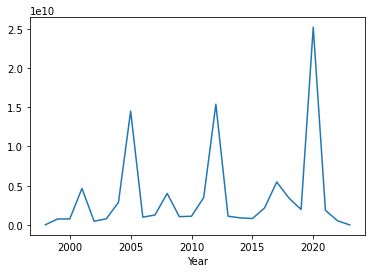

In [127]:
pa_time_df.groupby(by = 'Year')['sum'].sum().plot()

### For clusters 10/Bartholomew County and 5/Monroe: plot PA Project Amount Dollars by Year

In [136]:
cluster10_df = pa_time_df[pa_time_df['cluster']==10]

<AxesSubplot:xlabel='Year'>

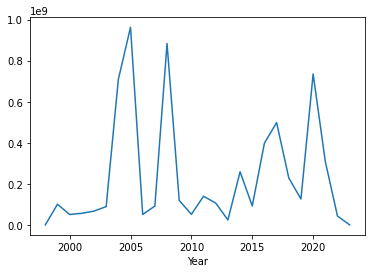

In [137]:
cluster10_df.groupby(by = 'Year')['sum'].sum().plot()

In [134]:
cluster5_df = pa_time_df[pa_time_df['cluster']==5]

<AxesSubplot:xlabel='Year'>

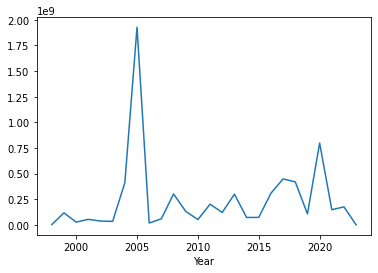

In [135]:
cluster5_df.groupby(by = 'Year')['sum'].sum().plot()

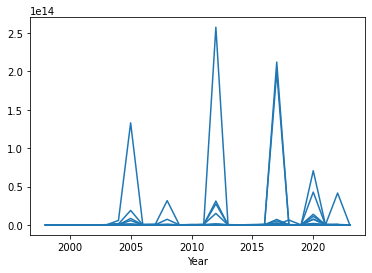

In [100]:
for x in range(20):
    tempdf = fema_df[fema_df['weatherCluster']==x].groupby(by =['Year'])['PA_projectAmount'].sum()
    tempdf.plot(subplots=True)
    

<AxesSubplot:xlabel='Year'>

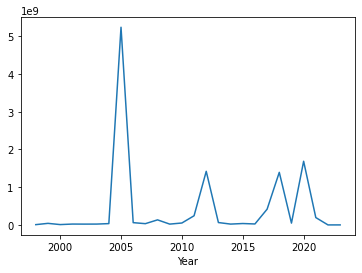

In [138]:
cluster12_df = pa_time_df[pa_time_df['cluster']==12]
cluster12_df.groupby(by = 'Year')['sum'].sum().plot()

<AxesSubplot:xlabel='Year'>

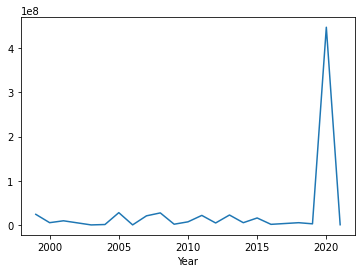

In [139]:
cluster4_df = pa_time_df[pa_time_df['cluster']==4]
cluster4_df.groupby(by = 'Year')['sum'].sum().plot()


In [141]:
cluster10_df.groupby(by = 'Year')['sum'].sum()

Year
1998      641757.2
1999   101179888.4
2000    51279114.4
2001    57204424.2
2002    67716244.7
2003    89825965.2
2004   708223013.1
2005   962364663.9
2006    51298744.8
2007    92474287.3
2008   883151947.9
2009   119926611.5
2010    52203124.6
2011   140000838.9
2012   106835012.2
2013    24737039.8
2014   259329376.7
2015    92632265.1
2016   398626413.5
2017   498518277.8
2018   229195179.9
2019   126704621.1
2020   735032448.6
2021   309041183.3
2022    43782047.4
2023      869269.6
Name: sum, dtype: float64

## Control charts 
https://towardsdatascience.com/quality-control-charts-guide-for-python-9bb1c859c051

             x          mR
0   24124631.7         NaN
1    5247727.1  18876904.6
2    9495841.3   4248114.2
3     167487.6   9328353.7
4    1062640.7    895153.2
5   27924705.4  26862064.7
6     254629.9  27670075.5
7   20723908.6  20469278.7
8   27352863.2   6628954.5
9    1776808.5  25576054.7
10   7145081.8   5368273.3
11  21697458.1  14552376.3
12   4577409.0  17120049.1
13  22581233.3  18003824.4
14   5197432.8  17383800.5
15  15890526.3  10693093.4
16   1469310.5  14421215.8
17   5185357.5   3716046.9
18   2640963.3   2544394.2
19 447517723.0 444876759.7
20    590798.5 446926924.5
Unit 19 out of individual control limits!
Unit 19 out of Moving Range control limits!
Unit 20 out of Moving Range control limits!


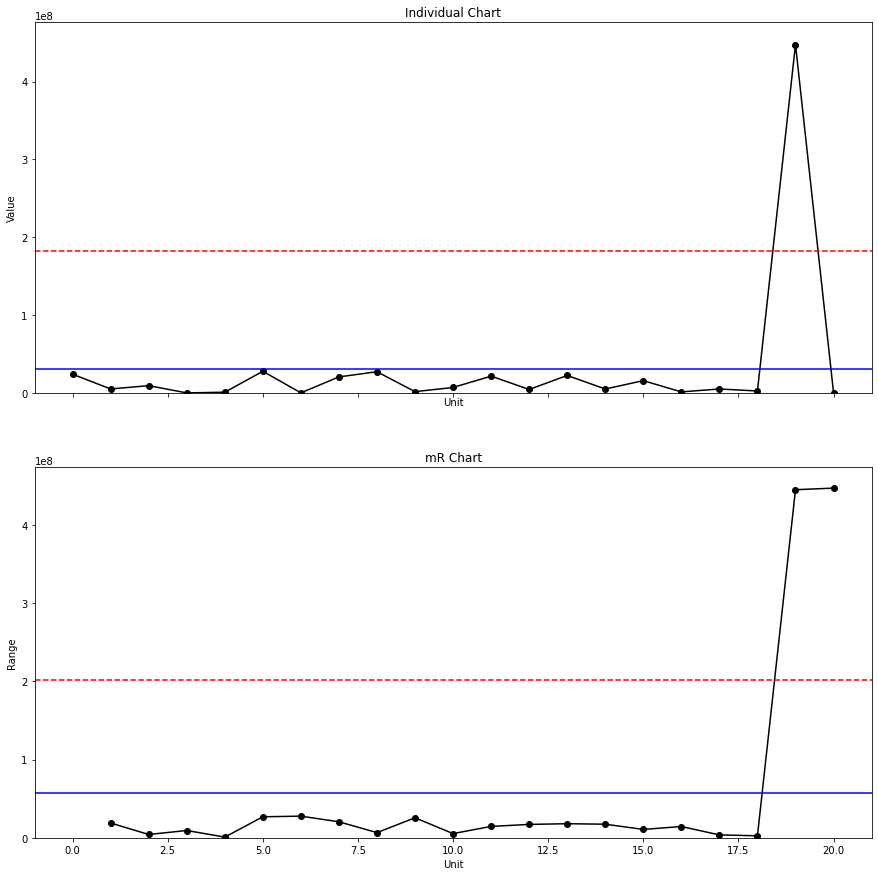

In [147]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

# Set random seed
np.random.seed(42)

# Create dummy data
#x = pd.Series(np.random.normal(loc=10, scale=2, size=10))
#x = fema_yr_df['PA_projectAmount']

x = pd.Series(cluster4_df.groupby(by = 'Year')['sum'].sum().to_list())

# Define list variable for moving ranges
MR = [np.nan]

# Get and append moving ranges
i = 1
for data in range(1, len(x)):
    MR.append(abs(x[i] - x[i-1]))
    i += 1

# Convert list to pandas Series objects    
MR = pd.Series(MR)

# Concatenate mR Series with and rename columns
#data = pd.concat([x,MR], axis=1).rename(columns={0:"x", 1:"mR"})
data = pd.concat([x,MR], axis=1).rename(columns={0:"x", 1:"mR"})

print(data)

# Plot x and mR charts
fig, axs = plt.subplots(2, figsize=(15,15), sharex=True)

# x chart
axs[0].plot(data['x'], linestyle='-', marker='o', color='black')
axs[0].axhline(statistics.mean(data['x']), color='blue')
axs[0].axhline(statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'red', linestyle = 'dashed')
axs[0].axhline(statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'red', linestyle = 'dashed')
axs[0].set_ylim(bottom=0)
axs[0].set_title('Individual Chart')
axs[0].set(xlabel='Unit', ylabel='Value')


# mR chart
axs[1].plot(data['mR'], linestyle='-', marker='o', color='black')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])]), color='blue')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])+3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='red', linestyle ='dashed')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])-3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='red', linestyle ='dashed')
axs[1].set_ylim(bottom=0)
axs[1].set_title('mR Chart')
axs[1].set(xlabel='Unit', ylabel='Range')



# Validate points out of control limits for x chart
i = 0
control = True
for unit in data['x']:
    if unit > statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128 or unit < statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128:
        print('Unit', i, 'out of individual control limits!')
        control = False
    i += 1
if control == True:
    print('All points within control limits.')
    
# Validate points out of control limits for mR chart
i = 0
control = True
for unit in data['mR']:
    if unit > statistics.mean(data['mR'][1:len(data['mR'])])+3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525 or unit < statistics.mean(data['mR'][1:len(data['mR'])])-3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525:
        print('Unit', i, 'out of Moving Range control limits!')
        control = False
    i += 1
if control == True:
    print('All points within control limits.')